# beeHealth Tutorial
### An introduction to Digital Health's library for localisation and activity metrics.
##### Michał Kozłowski, Miquel Perelló Nieto, Ryan McConville






The purpose of this tutorial is to introduce the functionality of this library and to provide a 'kick-start' for anyone aiming to use it, with the help of a few example scripts. We will initially concentrate on the two available examples, before moving onto ways in which this library can be expanded.

## Metrics for activity recognition

In this section we will cover the use of 3-dimensional accelerometer signal as a basis for preprocessing, stratification, validation, classification and subsequent activity recognition metrics extraction. 

### Firstly, let's take care of the dependencies:

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bhealth.visualisations import plot_metrics
from bhealth.visualisations import features_figure
from bhealth.visualisations import plot_features
from bhealth.visualisations import plot_test_train_splits
from bhealth import data_loading

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from bhealth.transforms import Transforms
from bhealth.metrics import Metrics
from bhealth.metric_wrappers import Wrapper

import warnings
warnings.filterwarnings('ignore')

### The function below calls the data loading script in the library. The data can be downloaded by following the instructions in the 'script' folder. The function outputs the raw data in the form of:

- 'ts' - timestamp
- 'xyz' - accelerometer data in 3-dimensions
- 'labels' - corresponding labels

In [2]:
def get_raw_ts_X_y():

    labels, ts, xyz = data_loading.data_loader_accelerometer(house_id='A')
    return ts, xyz, labels

### Preprocessing performs various transformations on the actual dataset, so called 'feature extraction'. Here, the data undergoes the extraction of selected features. The full list of feature transforms can be found in the file 'transforms.py' and their tests under 'tests/test_transforms.py'.

- The data is first windowed, and its overlap calculated (lines 5-11).
- Instantiation of the Transforms object (line 13).
- The appropriate feature transforms are selected and passed into the library as an array (lines 14-23).
- The window is then iterated across the entirety of the data, and each of the transforms is calculated (lines 25-39).
- Clean up operations follow (lines 41-49).

In [3]:
def preprocess_X_y(ts, X, y):
    new_X = []
    new_y = []

    winlength_seconds = 5
    overlap_seconds = 1
    print("Window size of "+str(winlength_seconds)+" seconds and overlap of "+str(float(overlap_seconds) / winlength_seconds)+"%")
    samples_per_sec = 50
    winlength = samples_per_sec * winlength_seconds
    current = winlength
    overlap = samples_per_sec * overlap_seconds

    transform = Transforms(window_length=winlength, window_overlap=overlap)
    print("Use number of mean crossings, spectral entropy as features...")
    feature_transforms = [transform.mean_crossings,
                          transform.spec_entropy,
                          transform.zero_crossings,
                          transform.interq,
                          transform.skewn,
                          transform.spec_energy,
                          transform.p25,
                          transform.p75,
                          transform.kurtosis]

    while True:
        windowed_raw = transform.slide(X)
        if len(windowed_raw) > 0:
            try:
                windowed_features = [ts[transform.current_position][0]]
            except Exception as e:
                print(e)
                break
            for function in feature_transforms:
                windowed_features.extend((np.apply_along_axis(function, 0, windowed_raw).tolist()))
            new_X.append(windowed_features)

            windowed_raw_labels = transform.slide(y, update=False)
            most_freq_label = np.bincount(windowed_raw_labels).argmax()
            new_y.append(most_freq_label)

    # Convert lists to Numpy arrays
    new_X = np.array(new_X)
    # Remove datetime from features
    new_X = new_X[:, 1:]
    new_y = np.array(new_y)

    new_X = transform.feature_selection(new_X, new_y, 'tree')

    return new_X, new_y

### The split is the performed for fair cross validation of the algorithms. In this example, the data is split into two partitions for training and testing data.

In [4]:
def split_train_test(X, y):
    # Create train and test partitions
    skf = StratifiedKFold(n_splits=2, shuffle=False)
    train_index, test_index = skf.split(X, y).__next__()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    plot_test_train_splits(y_train, y_test)
    return (X_train, y_train), (X_test, y_test)

### Classifier grid function selects the best set of parameters for a given classifier - in this case the classifier is a Random Forest. It will iteratively search through the provided parameters and output the set which gives best performance.

In [5]:
def get_classifier_grid():
    # Create cross-validation partitions from training
    # This should select the best set of parameters
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    clf = RandomForestClassifier()
    param_grid = {'n_estimators' : [200, 250],
                  'min_samples_leaf': [5, 10]}
    clf_grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, refit=True)
    return clf_grid

### The following function simply prints out the summary of the parameters and the cross validation accuracy. 

In [6]:
def print_summary(clf_grid, X_test, y_test):
    import numpy as np
    print('Best parameters are: {}'.format(clf_grid.best_params_))
    print("CV accuracy "+str(np.mean(clf_grid.cv_results_['mean_test_score'])))

    # The best model was fitted on the full training data, here it is tested only
    tt_score = clf_grid.score(X_test, y_test)
    print("Train / test split accuracy "+str(tt_score))

### Metrics are calculated in the following function. Its usage underpins the entire library. The metrics can be chosen, according to the needs of the user much like the feature transform functions.

- The current implementation can consider metrics across a variety of time spans - in this example we use daily and hourly metric calculation. This calls for the instantiation of the Wrapper class, where the user can specify what time spans should be used (lines 4-5).
- Then, the labes and timestamps are cast into Pandas DataFrame object. This is for the internal use of the metric calculation (lines 7-9).
- The metrics are then selected. This is done in a similar manner to the feature transforms above - through the use of array. The full list of implemented metrics can be found within the Wrapper class file 'metric_wrappers.py'. Note, that separate metrics for each of the time span duration can be chosen. 
- By running 'run_metric_array', the metrics are calculated and output in an array. This array outputs the metrics in the order in which they are provided by the user, i.e. in the example it would be 'duration_sitting', then 'number_of_unique_activities' and so  on.

In [7]:
def activity_metrics(labels, timestamps, span):
    """Outputs typical activity metrics."""

    descriptor_map = {
                'sitting' : [77],
                'walking' : [78],
                'washing' : [79],
                'eating'  : [80],
                'sleeping': [81],
                'studying': [82]
            }

    metrics = Wrapper(labels, timestamps, span, 1, 25, descriptor_map, adjecency=None)

    df_time = timestamps.astype('datetime64')
    df_time = pd.DataFrame(df_time, columns=['Time'])
    df_label = pd.DataFrame(labels, columns=['Label'])

    metric_array= [metrics.duration_sitting,
                   metrics.duration_walking,
                   metrics.duration_washing,
                   metrics.duration_eating,
                   metrics.duration_sleeping,
                   metrics.duration_studying,
                   metrics.number_of_unique_activities]

    metric_container, date_container = metrics.run_metric_array(metric_array)

    return metric_container, date_container

### The following structure in the 'main' function follows for all examples. The aim is to keep the entire pipeline the same:

1. get_raw_ts_X_y loads the data.
2. preprocess_X_y(ts, X, y) performs the preprocessing and feature extraction.
3. split_train_test(X, y) splits the data into test and training.
4. get_classifier_grid() performs the optimisation of the parameters.
5. clf_grid.fit(X_train, y_train) fits the model to data.
6. print_summary(clf_grid, X_test, y_test) validates the data and calculates the error.
7. activity_metrics(y_test, ts) uses the evaluated labels to provide metrics of activity relating to health.

Found 4 house folders.
Found 4 experiment folders.
Running folder:  1
Running folder:  2
Running folder:  3
Running folder:  4
(72766, 1)
(72766, 3)
(72766,)
Window size of 5 seconds and overlap of 0.2%
Use number of mean crossings, spectral entropy as features...
index 72800 is out of bounds for axis 0 with size 72766
[99 40 34  4  1  3  2]
[98 39 33  4  1  2  1]
Best parameters are: {'min_samples_leaf': 5, 'n_estimators': 250}
CV accuracy 0.7120786516853932
Train / test split accuracy 0.6502732240437158


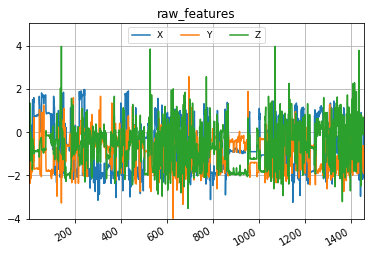

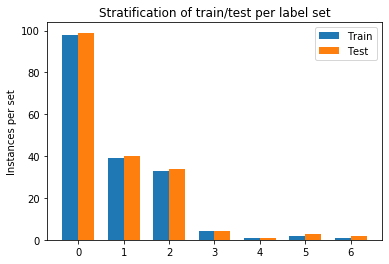

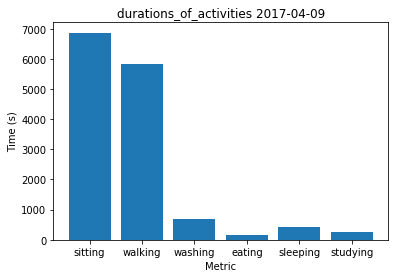

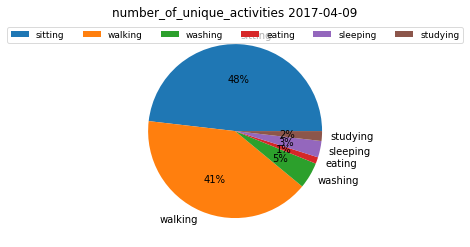

In [8]:
if __name__ == '__main__':
    ts, X, y = get_raw_ts_X_y()
    print(ts.shape)
    print(X.shape)
    print(y.shape)
    features_figure(X[0:X.size:50], feature_names=['X', 'Y', 'Z'])

    X, y = preprocess_X_y(ts, X, y)
    
    
    
    (X_train, y_train), (X_test, y_test) = split_train_test(X, y)
    clf_grid = get_classifier_grid()
    clf_grid.fit(X_train, y_train)
    print_summary(clf_grid, X_test, y_test)

    metric_container_daily, date_container_daily = activity_metrics(y, ts, 'daily')
    plot_metrics(metric_container_daily, date_container_daily)

    plt.show()

# Metrics for indoor localisation

Localisation works very similarly to activity recognition, in that the entire structure is maintained. The only differences are the preprocessing steps, as well as the choice of classifiers and parameters. Once again, we load by get_raw_ts_X_y. This time however, since the indoor localisation performance is highly dependent upon the environment it is in (as opposed to activity, which it invariant to environment), we have a choice of 4 different houses.

### Again, let's begin with dependencies:

In [9]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from bhealth import data_loading

from bhealth.visualisations import plot_metrics
from bhealth.visualisations import features_figure
from bhealth.visualisations import features_figure_scatter
from bhealth.visualisations import plot_test_train_splits

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

from bhealth.metrics import Metrics
from bhealth.transforms import Transforms
from bhealth.metric_wrappers import Wrapper

import warnings
warnings.filterwarnings('ignore')

### The below function, get_raw_ts_X_y, works in the same way as the function above. It again loads the appropriate data. Note however, that the actual dimensionality of this data changes with each house (i.e. how many unique features there are in the dataset. This corresponds to the number of Access Points (APs) used in the indoor localisation experiments.

In [17]:
def get_raw_ts_X_y(house_):

    ts, X, y = data_loading.data_loader_rssi(house_)
    return ts, X, y

### Data from APs comes in the form of Received Signal Strength Indication (RSSI). This is measured in dBm. In our example, we retain the raw data from the receiver, and perform no feature extraction. This is just an assumption however, and the user is free to perform any preprocessing they see fit.

In [18]:
def preprocess_X_y(ts, X, y):

    return X, y

### Split occurs in the same way as the above:

In [19]:
def split_train_test(X, y):
    # Create train and test partitions
    skf = StratifiedKFold(n_splits=2, shuffle=False)
    y = y.astype(int)
    train_index, test_index = skf.split(X, y).__next__()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    plot_test_train_splits(y_train, y_test)
    return (X_train, y_train), (X_test, y_test)

### For the purposes of indoor localisation, we expand the space of parameters and classifiers used in this example. Note, that here we are comparing a variety of different classifiers, each with their own parameter space. They are:

- Random Forest (rf)
- Logistic Regression (lr)
- Support Vector Classifier (svc)
- Support Vector Classifier with Radial Basis Function kernel

Ultimately, only rf is used to perform classification. This however can be easily changed, and new classifiers added.

In [20]:
def get_classifier_grid():
    # Create cross-validation partitions from training
    # This should select the best set of parameters
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    models = {'rf': {'model': RandomForestClassifier(),
                     'parameters': {'n_estimators': [200, 250],
                                    'min_samples_leaf': [1, 5, 10]}},
              'lr': {'model': LogisticRegression(penalty='l2'),
                     'parameters': {'C': [0.01, 0.1, 1, 10, 100]}},
              'svc': {'model': SVC(probability=True),
                      'parameters': [{'kernel': ['rbf'],
                                      'gamma': [1e-3, 1e-4],
                                      'C': [1, 10, 100, 1000]},
                                     {'kernel': ['linear'],
                                      'C': [1, 10, 100, 1000]}]},
              'svc-rbf': {'model': SVC(probability=True),
                          'parameters': [{'kernel': ['rbf'],
                                          'gamma': [1e-3, 1e-4],
                                          'C': [1, 10, 100, 1000]}, ]},
              }

    classifier_name = 'rf'

    steps = [('imputer', SimpleImputer(missing_values=np.nan,
                                       strategy='mean')),
             ('scaler', StandardScaler()),
             ('clf', models[classifier_name]['model'])]

    pipeline = Pipeline(steps)

    pipeline_parameters = {'clf__' + key: value for key, value in
                           models[classifier_name]['parameters'].items()}

    clf_grid = GridSearchCV(pipeline, param_grid=pipeline_parameters, cv=cv,
                            refit=True)
    return clf_grid

### This function again prints out the summary of the classification, much like in the activity example.

In [21]:
def print_summary(clf_grid, X_test, y_test):
    print('Best parameters are: {}'.format(clf_grid.best_params_))
    print("CV accuracy "+str(np.mean(clf_grid.cv_results_['mean_test_score'])))

    # The best model was fitted on the full training data, here tested only
    tt_score = clf_grid.score(X_test, y_test)
    print("Train / test split accuracy "+str(tt_score))

### Note, that the metrics for localisation follow much and the same evaluation strategy. This is deliberate, as the objective here is to familiarise the user, and allow them to easily add their own modalities.

In [22]:
def localisation_metrics(labels, timestamps, span):
    """Outputs typical activity metrics."""

    descriptor_map = {
        'foyer' : [0],
        'bedroom' : [1],
        'living_room' : [2],
        'bathroom' : [3]
    }

    adjecency = [[0, 2.5, 3, 3.3],
                 [2.5, 0, 6, 1.5],
                 [3, 6, 0, 4],
                 [3.3, 1.5, 4, 0]]

    metrics = Wrapper(labels, timestamps, span, 1, 25, descriptor_map, adjecency=adjecency)

    df_time = timestamps.astype('datetime64')
    df_time = pd.DataFrame(df_time, columns=['Time'])
    df_label = pd.DataFrame(labels, columns=['Label'])

    metric_array= [ metrics.walking_speed,
                    metrics.room_transfers,
                    metrics.number_of_unique_locations]

    metric_container, date_container = metrics.run_metric_array(metric_array)

    return metric_container, date_container

### The following structure differs from the activity recognition 'main' function. This is because, we perform classification and metric extraction from 4 unique houses, which all differ in their localisation environment. In order to run this example 'per house' we iterate each house on its own.

Found 1 house folders.
Found 4 experiment folders.
Running folder:  1
Running folder:  2
Running folder:  3
Running folder:  4
[46 13 84  6]
[46 12 83  5]
Best parameters are: {'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
CV accuracy 0.958904109589041
Train / test split accuracy 0.9530201342281879


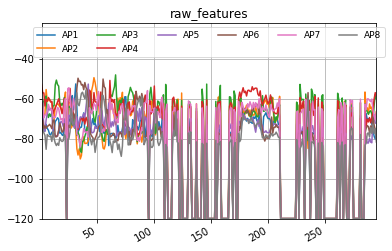

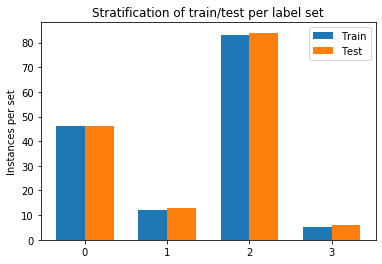

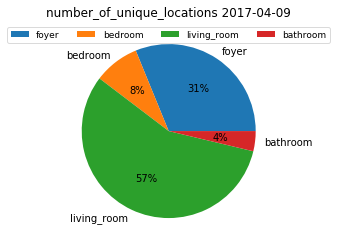

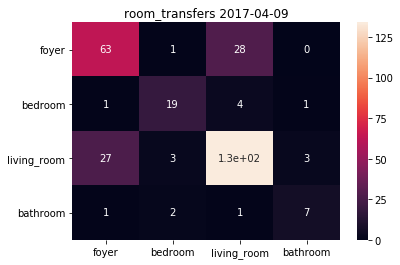

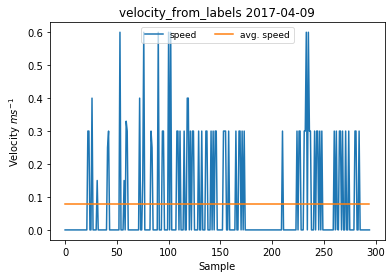

In [23]:
if __name__ == '__main__':
    houses = ['A']

    for house_ in houses:

        ts, X, y = get_raw_ts_X_y(house_)
        features_figure(X, feature_names=['AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8'])

        X, y = preprocess_X_y(ts, X, y)
        (X_train, y_train), (X_test, y_test) = split_train_test(X, y)
        clf_grid = get_classifier_grid()
        clf_grid.fit(X_train, y_train)
        print_summary(clf_grid, X_test, y_test)

        metric_container_daily, date_container_daily = localisation_metrics(y, ts, 'daily')
        plot_metrics(metric_container_daily, date_container_daily, labels_ = ['foyer', 'bedroom', 'living_room', 'bathroom'])

        plt.show()